In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select, table, column

In [4]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#display to determine which data set holds date
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe77006a750>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08}

In [10]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > year_ago).\
        order_by(Measurement.prcp).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(prcp)
prcp_df = prcp_df.rename(columns={0: "Date", 1: "Precipitation"})
prcp_df = prcp_df.set_index('Date')
prcp_df.sort_values(by='Date', inplace = True) 
#drop null values
prcp_df2 = prcp_df.dropna()
prcp_df2


#unique dates???

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,1.45
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


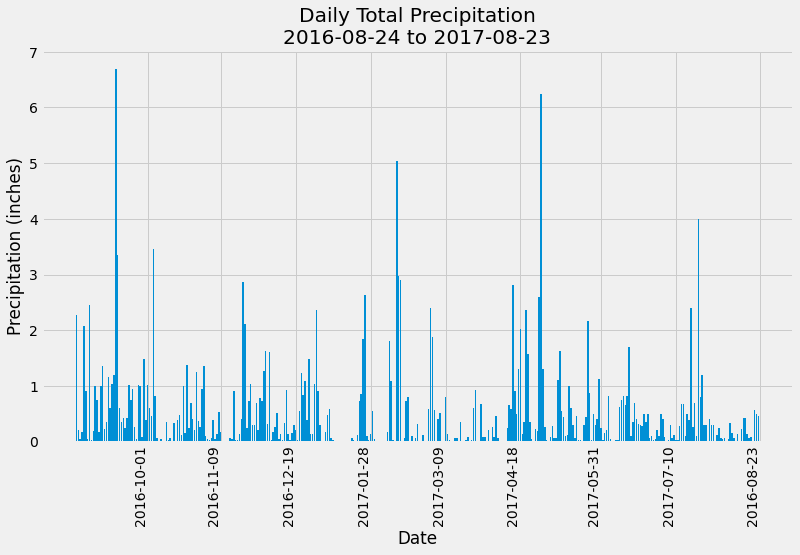

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 8))

#Set xticks
xticks =['2016-08-23', 
        '2016-10-01',
        '2016-11-09',
         '2016-12-19',
         '2017-01-28',
         '2017-03-09',
         '2017-04-18',
         '2017-05-31',
         '2017-07-10']

# Add x-axis and y-axis
ax.bar(prcp_df2.index.values,
       prcp_df2['Precipitation']
       )

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Daily Total Precipitation\n2016-08-24 to 2017-08-23"
       )
fig.autofmt_xdate()
plt.xticks(xticks, rotation=90)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_agg = prcp_df2.agg({"mean", 
                            "median", 
                            "var", 
                            "std", 
                            "sem", 
                            "count", 
                            "min", 
                            "max"})
summary_agg


,Precipitation
var,0.211865
min,0.000000
count,2015.000000
max,6.700000
sem,0.010254
std,0.460288
median,0.020000
mean,0.176462


# Exploratory Station Analysis

In [15]:
#Design a query to calculate the total number stations in the dataset

station_count = session.query(Measurement).group_by(Measurement.station).count()
print("Count:", station_count)

Count: 9


In [16]:
#Station names
for row in session.query(Station, Station.station).all():
    print(row)


(<sqlalchemy.ext.automap.station object at 0x7fe7c3320b10>, 'USC00519397')
(<sqlalchemy.ext.automap.station object at 0x7fe7d0916fd0>, 'USC00513117')
(<sqlalchemy.ext.automap.station object at 0x7fe7a010a190>, 'USC00514830')
(<sqlalchemy.ext.automap.station object at 0x7fe7a010a290>, 'USC00517948')
(<sqlalchemy.ext.automap.station object at 0x7fe7a010a310>, 'USC00518838')
(<sqlalchemy.ext.automap.station object at 0x7fe7a010a3d0>, 'USC00519523')
(<sqlalchemy.ext.automap.station object at 0x7fe7a010a450>, 'USC00519281')
(<sqlalchemy.ext.automap.station object at 0x7fe7a010a4d0>, 'USC00511918')
(<sqlalchemy.ext.automap.station object at 0x7fe7a010a550>, 'USC00516128')


In [72]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

# SQLAlchemy Query to GROUP BY and filter function
query = sqlalchemy.select([
    Measurement.station,
    sqlalchemy.func.count(Measurement.station)
    ]).group_by(Measurement.station
    ).order_by(func.count().desc())

# Fetch all the records
result = engine.execute(query).fetchall()

# View the records
for record in result:
    print("\n Station Count:", record)




 Station Count: ('USC00519281', 2772)

 Station Count: ('USC00519397', 2724)

 Station Count: ('USC00513117', 2709)

 Station Count: ('USC00519523', 2669)

 Station Count: ('USC00516128', 2612)

 Station Count: ('USC00514830', 2202)

 Station Count: ('USC00511918', 1979)

 Station Count: ('USC00517948', 1372)

 Station Count: ('USC00518838', 511)


In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# SQLAlchemy Query to GROUP BY and filter function

sel = [func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]


results = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()

for result in results:
    station_avg = [{"The minimum temperature for Station USC00519281 is": result[0]},
               {"The maximum temperature for Station USC00519281 is": result[1]},
               {"The average temperature for Station USC00519281 is": result[2]}]
station_avg



[{'The minimum temperature for Station USC00519281 is': 54.0},
 {'The maximum temperature for Station USC00519281 is': 85.0},
 {'The average temperature for Station USC00519281 is': 71.66378066378067}]

In [77]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_one = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date > year_ago).\
        filter(Measurement.station == 'USC00519281').\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column to plot
station_df = pd.DataFrame(station_one)
station_df = station_df.rename(columns={0: "Date", 1: "TOBS"})
station_df = station_df.set_index('Date')
station_df

,TOBS
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


ValueError: too many values to unpack (expected 2)

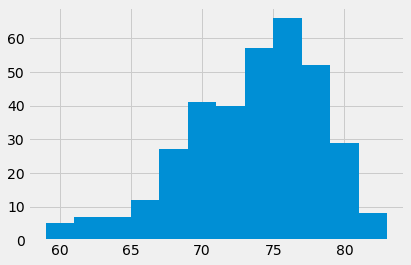

In [76]:
# Save the query results as a Pandas DataFrame and set the index to the date column
station_df = pd.DataFrame(station_one)
station_df = station_df.rename(columns={0: "Date", 1: "TOBS"})
station_df = station_df.set_index('Date')
station_df.sort_values(by='Date', inplace = True) 
station_df

#plot historgram
fig, ax = plt.hist(x, bins=12)

# Add x-axis and y-axis
x=(station_df['TOBS'])


# Set title and labels for axes
ax.hist(xlabel="TOBS",
       ylabel="Frequency",
       title="TOBS Histogram \n2016-08-24 to 2017-08-23"
       )
fig.autofmt_xdate()
plt.xticks(xticks, rotation=90)
plt.show()

# Close session

In [78]:
# Close Session
session.close()